In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
fred = pd.read_csv(r"./data/FRED/FRED3_Entire_Database_2021.csv", low_memory=False, header=0, skiprows=range(1, 10), encoding="latin1") # FRED v3
meta = pd.read_csv(r"./data/FRED/FRED3_Column_Definitions_2021.csv", usecols=["column_id", "name", "units"], index_col="column_id") # metadata for FRED v3 (column names, units etc.)
lookup = pd.read_csv(r"./data/plantlookup.csv", # https://github.com/traitecoevo/taxonlookup/releases/download/v1.1.5/plant_lookup.csv
                     low_memory=False, encoding="latin1", index_col=0) # https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/2041-210X.12517

In [37]:
# traits relevent to the root economics space (RES)

COLLABORATION_GRADIENT_TRAITS = [
    "F00679", # RD
    "F00727", # SRL
    "F00718", #	Specific root area (SRA)
    "F00104", # RCT
    "F00622", # Mycorrhiza_Fraction root length colonized by AM mycorrhizae
    "F00626", # Mycorrhiza_Fraction root length colonized by EM mycorrhizae
    "F00638", # Mycorrhiza_Fraction of root length
    "F00645"  # Mycorrhiza_Type_Data - not technically a root trait, just a relevant info
]

CONSERVATION_GRADIENT_TRAITS = [
    "F00709", # RTD
    "F00277", #	Root P content
    "F00261", # Root N content
    "F00358"  # Root lignin content
]

PLANT_TAXONOMY_ACCEPTED_COLUMNS = [
    "F01286", # Genus of plant according to The Plant List
    "F01287", # Species epithet of plant according to The Plant List
    "F01289", # Family of plant according to The Plant List
    "F01290" # Order of plant. For Angiosperms, this was determined using the Angiosperm Phylogeny Website (APW): Stevens, P. F. (2001 onwards). Angiosperm Phylogeny Website. 
             # Version 14, July 2017 [and more or less continuously updated since]. Online at http://www.mobot.org/MOBOT/research/APweb/. 
             # For other plant groups (Gymnosperms, Pteridophytes, and Bryophytes) this was determined first using APW, but in cases where there were discrepancies within APW,
             # and to maintain consistency in suffix nomenclature (i.e. all orders ending in “iales”), additional sources were used including the USDA Plants Database 
             # (https://plants.usda.gov/) and the Missouri Botanical Garden (http://www.missouribotanicalgarden.org/plant-science/plant-science/research/plant-identification.aspx).
]

ESSENTIAL_COLUMNS = [
    "F00018", # genus
    "F00019", # species
    "F00056", # root order
    "F00645"  # mycorrhizal type
]

In [38]:
FRED_MISSPELT_GENERA = {
     "Aglaria": "Aglaia",
     "Aporusa": "Aporosa",
     "Artrocarpus": "Artocarpus",
     "Atrocarpus": "Artocarpus",
     "Brosimun": "Brosimum",
     "Diospyrus": "Diospyros",
     "Gletitsia": "Gleditsia",
     "Parakmeria": "Magnolia", # Parakmeria lotungensis is synonym for Magnolia lotungensis
     "Paramichelia": "Magnolia", # Paramichelia baillonii is synonym for Magnolia baillonii
     "Polyanthia": "Polyalthia",
     "Tabebuis": "Tabebuia",
     "Tabernamontana": "Tabernaemontana",
     "Tsoongiodendron": "Magnolia" # Tsoongiodendron odorum is synonym for Magnolia odora
}

LOOKUP_MISSING_GENERA = {
    "Carrizo": "Rutaceae",
    "Cuoropita": "Lecythidaceae",
    "Tsoongiodendron": "Magnoliaceae",
    "Schizonepeta": "Lamiaceae",
    "Schyzolobium": "Fabaceae",
    "Swingle": "Rutaceae",
    "x Citrofortunella": "Rutaceae" # Citrofortunella
}

## ___1) Missing values___
--------------------

In [39]:
fred.loc[:, COLLABORATION_GRADIENT_TRAITS + CONSERVATION_GRADIENT_TRAITS + ESSENTIAL_COLUMNS + PLANT_TAXONOMY_ACCEPTED_COLUMNS].isna().mean()

F00679    0.838835
F00727    0.843627
F00718    0.961637
F00104    0.993828
F00622    0.989596
F00626    0.999685
F00638    0.988390
F00645    0.829148
F00709    0.882847
F00277    0.966550
F00261    0.881728
F00358    0.986693
F00018    0.244029
F00019    0.255499
F00056    0.871533
F00645    0.829148
F01286    0.250743
F01287    0.256478
F01289    0.243189
F01290    0.243015
dtype: float64

In [40]:
CHOSEN_RES_TRAITS = [
    "F00679", # RD
    "F00727", # SRL
    "F00261", # RP
    "F00709" # RTD
]

In [41]:
# subset the dataframe to pick only the columns with least amount of missing values
fred.loc[:, CHOSEN_RES_TRAITS + ESSENTIAL_COLUMNS + PLANT_TAXONOMY_ACCEPTED_COLUMNS]

,F00679,F00727,F00261,F00709,F00018,F00019,F00056,F00645,F01286,F01287,F01289,F01290
0,NaN,NaN,NaN,NaN,Dicranopteris,dichotoma,1.0,AM,Dicranopteris,linearis,Gleicheniaceae,Gleicheniales
1,NaN,NaN,NaN,NaN,Dicranopteris,dichotoma,2.0,AM,Dicranopteris,linearis,Gleicheniaceae,Gleicheniales
2,NaN,NaN,NaN,NaN,Dicranopteris,dichotoma,3.0,AM,Dicranopteris,linearis,Gleicheniaceae,Gleicheniales
3,NaN,NaN,NaN,NaN,Cunninghamia,lanceolata,1.0,AM,Cunninghamia,lanceolata,Cupressaceae,Pinales
4,NaN,NaN,NaN,NaN,Cunninghamia,lanceolata,2.0,AM,Cunninghamia,lanceolata,Cupressaceae,Pinales
...,...,...,...,...,...,...,...,...,...,...,...,...
57185,NaN,0.567694,8.666348,NaN,Diplopterygium,chinense,NaN,NaN,Diplopterygium,chinensis,Gleicheniaceae,Gleicheniales
57186,NaN,0.693820,8.520457,NaN,Diplopterygium,chinense,NaN,NaN,Diplopterygium,chinensis,Gleicheniaceae,Gleicheniales
57187,NaN,3.364970,14.188312,NaN,Osmunda,japonica,NaN,NaN,Osmunda,japonica,Osmundaceae,Osmundaceae
57188,NaN,2.174190,14.849199,NaN,Osmunda,japonica,NaN,NaN,Osmunda,japonica,Osmundaceae,Osmundaceae


In [49]:
# get rid of records with missing values for the 4 chosen root traits and genus name
fred.loc[:, CHOSEN_RES_TRAITS + ESSENTIAL_COLUMNS + PLANT_TAXONOMY_ACCEPTED_COLUMNS].dropna(subset=CHOSEN_RES_TRAITS)# + ["F00018"])

,F00679,F00727,F00261,F00709,F00018,F00019,F00056,F00645,F01286,F01287,F01289,F01290
302,0.250000,71.600000,19.700000,0.440000,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
303,0.290000,45.900000,14.900000,0.300000,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
304,0.380000,68.100000,20.400000,0.320000,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
382,0.142951,447.167648,18.478265,0.169294,Populus,trichocarpa,1.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
383,0.249630,166.388374,14.456530,0.160036,Populus,trichocarpa,2.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
...,...,...,...,...,...,...,...,...,...,...,...,...
54941,0.400000,51.410000,16.500000,0.150000,Allium,tenuissimum,NaN,NaN,Allium,tenuissimum,Amaryllidaceae,Asparagales
54942,0.490000,31.670000,16.500000,0.170000,Allium,bidentatum,NaN,NaN,Allium,bidentatum,Amaryllidaceae,Asparagales
54943,0.510000,26.060000,16.500000,0.190000,Allium,bidentatum,NaN,NaN,Allium,bidentatum,Amaryllidaceae,Asparagales
54944,0.230000,102.900000,12.200000,0.230000,Chamaerhodos,erecta,NaN,NaN,Chamaerhodos,erecta,Rosaceae,Rosales


In [52]:
# see whether accepted genus source has info where the data source genus name is missing!!
fred.loc[:, CHOSEN_RES_TRAITS + ESSENTIAL_COLUMNS + PLANT_TAXONOMY_ACCEPTED_COLUMNS].dropna(subset=CHOSEN_RES_TRAITS).query("F00018.isna()") # nada

,F00679,F00727,F00261,F00709,F00018,F00019,F00056,F00645,F01286,F01287,F01289,F01290
302,0.250000,71.600000,19.700000,0.44,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
303,0.290000,45.900000,14.900000,0.30,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
304,0.380000,68.100000,20.400000,0.32,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1603,0.510000,30.160000,12.400000,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1604,0.490000,35.250000,8.200000,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1605,0.510000,32.550000,9.700000,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1606,0.510000,31.770000,9.100000,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1607,0.490000,34.440000,8.300000,0.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1608,0.490000,27.630000,7.000000,0.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1609,0.490000,33.500000,7.100000,0.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# drop the rows that do not have a genus name
fred.loc[:, CHOSEN_RES_TRAITS + ESSENTIAL_COLUMNS + PLANT_TAXONOMY_ACCEPTED_COLUMNS].dropna(subset=CHOSEN_RES_TRAITS + ["F00018"])

,F00679,F00727,F00261,F00709,F00018,F00019,F00056,F00645,F01286,F01287,F01289,F01290
382,0.142951,447.167648,18.478265,0.169294,Populus,trichocarpa,1.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
383,0.249630,166.388374,14.456530,0.160036,Populus,trichocarpa,2.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
384,0.425085,60.723679,10.760881,0.171351,Populus,trichocarpa,3.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
385,0.687417,30.725767,9.130448,0.191318,Populus,trichocarpa,4.0,NaN,Populus,trichocarpa,Salicaceae,Malpighiales
386,0.175513,330.424588,22.065220,0.169294,Populus,tremula,1.0,NaN,Populus,tremula,Salicaceae,Malpighiales
...,...,...,...,...,...,...,...,...,...,...,...,...
54941,0.400000,51.410000,16.500000,0.150000,Allium,tenuissimum,NaN,NaN,Allium,tenuissimum,Amaryllidaceae,Asparagales
54942,0.490000,31.670000,16.500000,0.170000,Allium,bidentatum,NaN,NaN,Allium,bidentatum,Amaryllidaceae,Asparagales
54943,0.510000,26.060000,16.500000,0.190000,Allium,bidentatum,NaN,NaN,Allium,bidentatum,Amaryllidaceae,Asparagales
54944,0.230000,102.900000,12.200000,0.230000,Chamaerhodos,erecta,NaN,NaN,Chamaerhodos,erecta,Rosaceae,Rosales


In [ ]:
# fine root??
# diameter < 1.0 mm (Valverde‐Barrantes et al., 2017)
# diameter < 2.0 mm (Laliberté, 2017)
# 

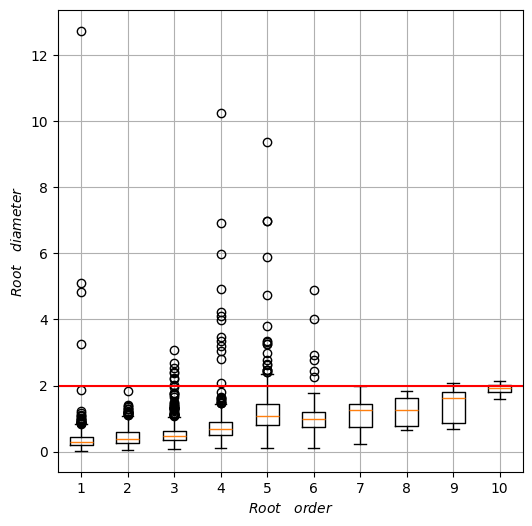

In [26]:
# root order and root diameter

fig, axes = plt.subplots()
fig.set_size_inches(6, 6)
axes.boxplot([group.F00679 for (_, group) in fred.loc[:, ["F00679", "F00056"]].dropna().groupby("F00056")], label=[order for (order, _) in fred.loc[:, ["F00679", "F00056"]].dropna().groupby("F00056")])
axes.hlines(y=2, xmin=axes.get_xlim()[0], xmax=axes.get_xlim()[1], color="red")
axes.set_ylabel(r"$Root\hspace{1}diameter$")
axes.set_xlabel(r"$Root\hspace{1}order$")
axes.grid()
plt.show()

# fred.loc[:, COLLABORATION_GRADIENT_TRAITS + CONSERVATION_GRADIENT_TRAITS + PLANT_TAXONOMY_ACCEPTED_COLUMNS + ESSENTIAL_COLUMNS].query("F00056.isin((1,2,3))").F00679

In [29]:
fred.loc[:, ["F00679", "F00056"]].dropna().query("F00679<2").F00056.value_counts()

F00056
1.0     1981
2.0     1264
3.0      491
4.0      366
5.0      312
6.0       44
7.0       30
8.0       14
9.0        7
10.0       3
Name: count, dtype: int64